In [51]:
#libreria para manejo de NDARRAY
import numpy as np;
#libreria para graficar
#tipo matlab: pyplot
#objetual: figure, axes
import matplotlib.pyplot as plt
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym

In [26]:

ruta_carpeta = './control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = './parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


In [31]:
np.shape(datos_matriz[0][:,:,119])

(8, 2000)

In [64]:
k=symbols("k")
a=sym.exp(k)
a=a.subs(k,1)
float(a)

2.718281828459045

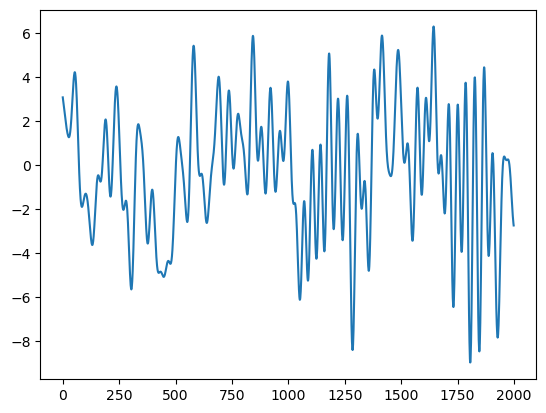

In [25]:
a=datos_matriz[0]
plt.plot(a[1,0*2000:0*2000+2000])

In [103]:
def spectraldensity(xn,epoca,paciente):
    xn=xn[paciente]
    xn=xn[:,:,epoca]
    sums_k_list=[]
    for canal in xn:
        N=len(canal)
        nl=np.arange(N)
        sums_k=0
        for n in nl:
            w_n=0.42-0.5*np.cos((2*np.pi*n)/(N-1))
            s_k=np.abs(canal*w_n*np.exp((-complex(0,1)*np.pi*nl*n)/N))**2
            sums_k+=s_k
        sums_k_list.append(sums_k/N)
    return sums_k_list

In [ ]:
x=spectraldensity(datos_matriz,119,0)

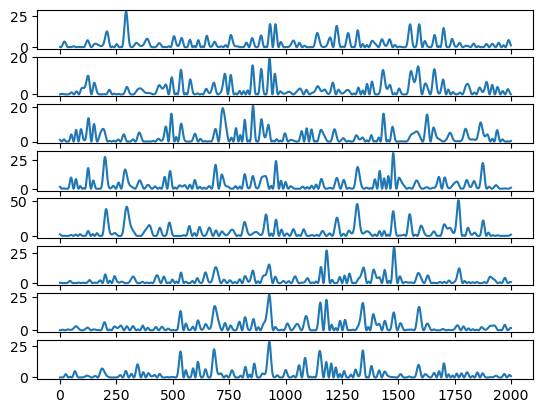

In [116]:
for i in range(len(x)):
    plt.subplot(8,1,i+1)
    plt.plot(x[i])
plt.show()